Open Play Shots - Expected Miss Model - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import open_shots_file_path
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
new_version = 4
model_name = "expected_miss_open"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_MISS

Features

In [6]:
FEATURES = ModellingDataContract.open_goal_modelling_feature_list

Load Data

In [7]:
df_modelling = pd.read_csv(open_shots_file_path)
df_modelling.tail()

Chain_Number Initial_State Final_State   Order  Quarter  \
9211           211        kickIn      behind  1705.0        4   
9212           212        kickIn        goal  1740.0        4   
9213           218      possGain        goal  1837.0        4   
9214           227       throwIn        goal  1901.0        4   
9215           233      possGain        goal  1971.0        4   

      Quarter_Duration_Chain_Start  Quarter_Duration Team_Chain     Team  \
9211                           744             775.0     Sydney   Sydney   
9212                           787             900.0    Geelong  Geelong   
9213                          1136            1198.0    Geelong  Geelong   
9214                          1452            1458.0    Geelong  Geelong   
9215                          1744            1753.0     Sydney   Sydney   

               Player AFL_API_Player_ID Description     x     y     Disposal  \
9211       Tom Papley        Tom_Papley        Kick  56.0 -36.0  ineffective   
9212  Brandan Parfitt   Brandan_Parfitt        Kick  75.0   0.0    effective   
9213    Sam De Koning     Sam_De_Koning        Kick  78.0   1.0    effective   
9214     Joel Selwood      Joel_Selwood        Kick  37.0  17.0    effective   
9215       Tom Papley        Tom_Papley        Kick  48.0 -20.0    effective   

      Shot_At_Goal  Behind_Detail  Venue_Width  Venue_Length Home_Team  \
9211          True            NaN          141           160   Geelong   
9212          True            NaN          141           160   Geelong   
9213          True            NaN          141           160   Geelong   
9214          True            NaN          141           160   Geelong   
9215          True            NaN          141           160   Geelong   

     Away_Team Home_Team_Direction_Q1               Match_ID Round_ID  Year  \
9211    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   
9212    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   
9213    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   
9214    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   
9215    Sydney                   left  2022F4_Geelong_Sydney   2022F4  2022   

      Goal  Behind  Miss  Score  Home_Score  Away_Score  Home_Current_Score  \
9211     0       1     0      1           0           1               107.0   
9212     1       0     0      6           6           0               113.0   
9213     1       0     0      6           6           0               119.0   
9214     1       0     0      6           6           0               125.0   
9215     1       0     0      6           0           6               137.0   

      Away_Current_Score  Current_Margin Event_Type0        Event_Type1  \
9211                32.0            75.0        Kick             Gather   
9212                33.0            80.0        Kick  Handball Received   
9213                39.0            80.0        Kick             Gather   
9214                45.0            80.0        Kick             Gather   
9215                45.0            92.0        Kick             Bounce   

            Event_Type2        Event_Type3    x0    x1    x2    x3    y0  \
9211               Kick  Handball Received  56.0  48.0   7.0   4.0 -36.0   
9212           Handball     Loose Ball Get  75.0  75.0  76.0  75.0   0.0   
9213               Kick  Handball Received  78.0  78.0  65.0  64.0   1.0   
9214           Knock On           Handball  37.0  37.0  43.0  34.0  17.0   
9215  Handball Received           Handball  48.0  38.0  35.0  37.0 -20.0   

        y1    y2    y3  Quarter_Duration0  Quarter_Duration1  \
9211 -44.0 -47.0 -37.0              775.0              771.0   
9212  -1.0  -5.0  -6.0              900.0              899.0   
9213   1.0 -12.0  -9.0             1198.0             1193.0   
9214  19.0  20.0  25.0             1458.0             1457.0   
9215 -31.0 -33.0 -37.0             1753.0             

In [8]:
df_modelling[['ballUp', 'centreBounce', 'kickIn', 'possGain', 'throwIn']] = pd.get_dummies(df_modelling['Initial_State'])

In [9]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [10]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [11]:
X_test.head()

Chain_Number Initial_State Final_State   Order  Quarter  \
6             46      possGain        goal   476.0        1   
7             50      possGain      behind   512.0        1   
8             79      possGain        goal   747.0        2   
13            96  centreBounce        goal   899.0        2   
16           141  centreBounce      behind  1250.0        3   

    Quarter_Duration_Chain_Start  Quarter_Duration      Team_Chain  \
6                           1383            1389.0          Sydney   
7                           1462            1500.0  Brisbane Lions   
8                            709             720.0          Sydney   
13                          1368            1381.0  Brisbane Lions   
16                           901             912.0  Brisbane Lions   

              Team            Player AFL_API_Player_ID Description     x  \
6           Sydney      Isaac Heeney      Isaac_Heeney        Kick  56.0   
7   Brisbane Lions   Oscar McInerney   Oscar_McInerney        Kick  65.0   
8           Sydney         Sam Wicks         Sam_Wicks        Kick  41.0   
13  Brisbane Lions  Lincoln McCarthy  Lincoln_McCarthy        Kick  38.0   
16  Brisbane Lions   Keidean Coleman   Keidean_Coleman        Kick  36.0   

       y     Disposal  Shot_At_Goal  Behind_Detail  Venue_Width  Venue_Length  \
6    6.0    effective          True            NaN          138           156   
7  -15.0  ineffective          True            NaN          138           156   
8   18.0    effective          True            NaN          138           156   
13   7.0    effective          True            NaN          138           156   
16 -31.0  ineffective          True            NaN          138           156   

         Home_Team Away_Team Home_Team_Direction_Q1  \
6   Brisbane Lions    Sydney                  right   
7   Brisbane Lions    Sydney                  right   
8   Brisbane Lions    Sydney                  right   
13  Brisbane Lions    Sydney                  right   
16  Brisbane Lions    Sydney                  right   

                       Match_ID Round_ID  Year  Goal  Behind  Score  \
6   202101_BrisbaneLions_Sydney   202101  2021     1       0      6   
7   202101_BrisbaneLions_Sydney   202101  2021     0       1      1   
8   202101_BrisbaneLions_Sydney   202101  2021     1       0      6   
13  202101_BrisbaneLions_Sydney   202101  2021     1       0      6   
16  202101_BrisbaneLions_Sydney   202101  2021     0       1      1   

    Home_Score  Away_Score  Home_Current_Score  Away_Current_Score  \
6            0           6                19.0                 9.0   
7            1           0                19.0                15.0   
8            0           6                20.0                40.0   
13           6           0                38.0                46.0   
16           1           0                57.0                71.0   

    Current_Margin Event_Type0          Event_Type1     Event_Type2  \
6             10.0        Kick    Handball Received        Handball   
7              4.0        Kick  Hard Ball Get Crumb           Spoil   
8            -20.0        Kick    Handball Received        Handball   
13            -8.0        Kick       Loose Ball Get           Spoil   
16           -14.0        Kick        Hard Ball Get  Contest Target   

              Event_Type3    x0    x1    x2    x3    y0    y1    y2    y3  \
6       Handball Received  56.0  58.0  58.0  58.0   6.0  21.0  25.0  26.0   
7   Kick Inside 50 Result  65.0  62.0  60.0  60.0 -15.0 -16.0 -17.0 -17.0   
8       Handball Received  41.0  38.0  37.0  36.0  18.0  16.0  15.0  15.0   
13  Kick Inside 50 Result  38.0  39.0  46.0  46.0   7.0   4.0  -1.0  -1.0   
16            Ground Kick  36.0  32.0  29.0   6.0 -31.0 -32.0 -31.0  -2.0   

    Quarter_Duration0  Quarter_Duration1  Quarter_Duration2  \
6              1389.0             1389.0             1388.0   
7              1500.0             1499.0             1497.0   
8 

Preprocess Data

In [12]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [13]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]

In [14]:
X_train_preproc.shape, X_test_preproc.shape

((5897, 17), (1844, 17))

In [15]:
X_train_preproc.head()

x0    x1    x2    x3  Distance_Since_Last_Action  \
0  26.0  18.0  11.0   6.0                    8.246211   
3  34.0  19.0  10.0   7.0                   15.132746   
4  40.0  36.0  34.0  32.0                    4.123106   
5  27.0  28.0  34.0  35.0                    3.162278   
9  46.0  41.0  35.0  30.0                    5.000000   

   Distance_to_Middle_Goal  Angle_to_Middle_Goal  Visible_Goal_Angle  ballUp  \
0                56.080300              0.383818            0.106164       0   
3                46.486557              0.328553            0.130930       0   
4                39.560081              0.281772            0.156423       0   
5                59.682493              0.546167            0.091898       0   
9                32.062439              0.062419            0.201226       0   

   centreBounce  kickIn  possGain  throwIn  Distance_to_Right_Goal_x  \
0             1       0         0        0                      52.0   
3             0       0         1        0                      44.0   
4             0       0         1        0                      38.0   
5             0       0         1        0                      51.0   
9             0       0         0        1                      32.0   

   Distance_to_Middle_y  Chain_Duration  Time_Since_Last_Action  
0                  21.0            26.0                     1.0  
3                  15.0            13.0                     2.0  
4                  11.0             5.0                     3.0  
5                  31.0            45.0                     1.0  
9                   2.0            13.0                     0.0

In [16]:
X_test_preproc.head()

x0    x1    x2    x3  Distance_Since_Last_Action  \
6   56.0  58.0  58.0  58.0                   15.132746   
7   65.0  62.0  60.0  60.0                    3.162278   
8   41.0  38.0  37.0  36.0                    3.605551   
13  38.0  39.0  46.0  46.0                    3.162278   
16  36.0  32.0  29.0   6.0                    4.123106   

    Distance_to_Middle_Goal  Angle_to_Middle_Goal  Visible_Goal_Angle  ballUp  \
6                 22.803509              0.266252            0.276208       0   
7                 19.849433              0.856706            0.216802       0   
8                 41.146081              0.452778            0.140721       0   
13                40.607881              0.173246            0.156216       0   
16                52.201533              0.635838            0.099014       0   

    centreBounce  kickIn  possGain  throwIn  Distance_to_Right_Goal_x  \
6              0       0         1        0                      22.0   
7              0       0         1        0                      13.0   
8              0       0         1        0                      37.0   
13             1       0         0        0                      40.0   
16             1       0         0        0                      42.0   

    Distance_to_Middle_y  Chain_Duration  Time_Since_Last_Action  
6                    6.0             6.0                     0.0  
7                   15.0            38.0                     1.0  
8                   18.0            11.0                     0.0  
13                   7.0            13.0                     2.0  
16                  31.0            11.0                     2.0

Load Model

In [17]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [18]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3797636923566364, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0001704251384576935, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.72...
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=82, missing=nan,
              monotone_constraints={'Angle_to_Middle_Goal': -1,
                                    'Distance_Since_Last_Action': 1,
                                    'Distance_to_Middle_Goal': -1,
                                    'Visible_Goal_Angle': 1, 'x0': -1},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Get Predictions

In [19]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

In [20]:
train_probas = super_xgb.predict_proba(X_train_preproc)[:, 1]
test_probas = super_xgb.predict_proba(X_test_preproc)[:, 1]

In [21]:
train_cal_probas = super_xgb.predict_proba(X_train_preproc, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test_preproc, calibrate=True)

Compare Model

In [22]:
compare_train_data = pd.read_csv(compare_train_predictions_file_path)
compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [23]:
compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
                                                          'xgb_probas':'old_probas'})
compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
                                                        'xgb_probas':'old_probas'})

In [24]:
training_data.shape, compare_train_data.shape

((5897, 79), (7208, 23))

In [25]:
training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [26]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas
training_data['xgb_cal_probas'] = train_cal_probas

train_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name='xgb_probas',
                                       compare_label_name="xgb_preds"
                                       )

In [27]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas
test_data['xgb_cal_probas'] = test_cal_probas

test_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                       compare_name = "xgb_probas",
                                       compare_label_name="xgb_preds"
                                       )

Model Averages

In [28]:
training_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas', 'old_probas']].describe()

Miss   xgb_probas  xgb_cal_probas   old_probas
count  5897.000000  5897.000000     5897.000000  4584.000000
mean      0.207224     0.208919        0.205899     0.213518
std       0.405352     0.088821        0.068326     0.085200
min       0.000000     0.042120        0.053609     0.059425
25%       0.000000     0.141409        0.155585     0.150814
50%       0.000000     0.203432        0.207957     0.210389
75%       0.000000     0.266304        0.254451     0.269259
max       1.000000     0.554901        0.410948     0.477720

In [29]:
test_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas', 'old_probas']].describe()

Miss   xgb_probas  xgb_cal_probas  old_probas
count  1844.000000  1844.000000     1844.000000  397.000000
mean      0.207158     0.206028        0.203594    0.205855
std       0.405380     0.089080        0.068429    0.085368
min       0.000000     0.045674        0.057755    0.062619
25%       0.000000     0.137016        0.151590    0.134162
50%       0.000000     0.198508        0.204054    0.202679
75%       0.000000     0.261874        0.251364    0.261110
max       1.000000     0.512584        0.392384    0.438289

Plots

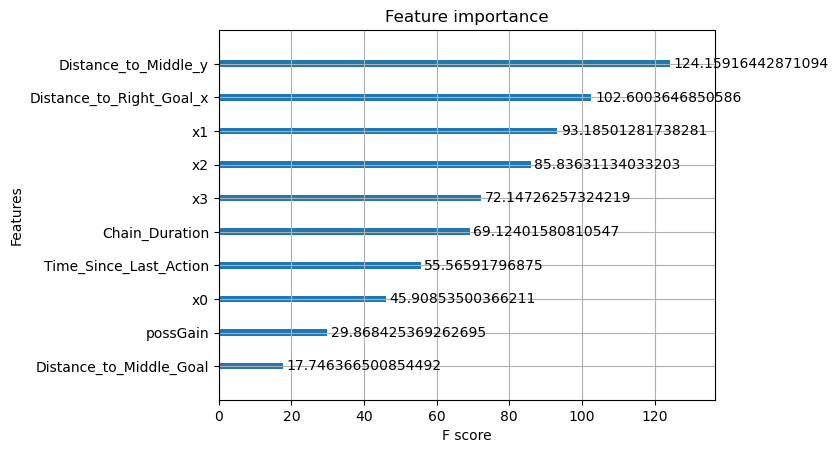

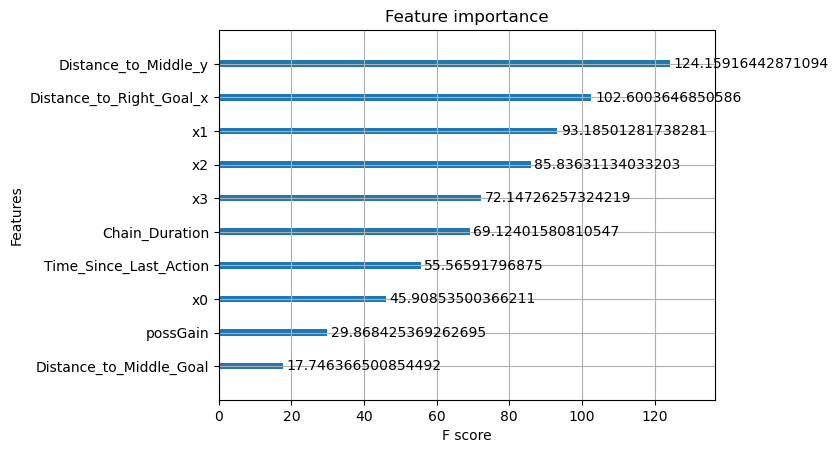

In [30]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

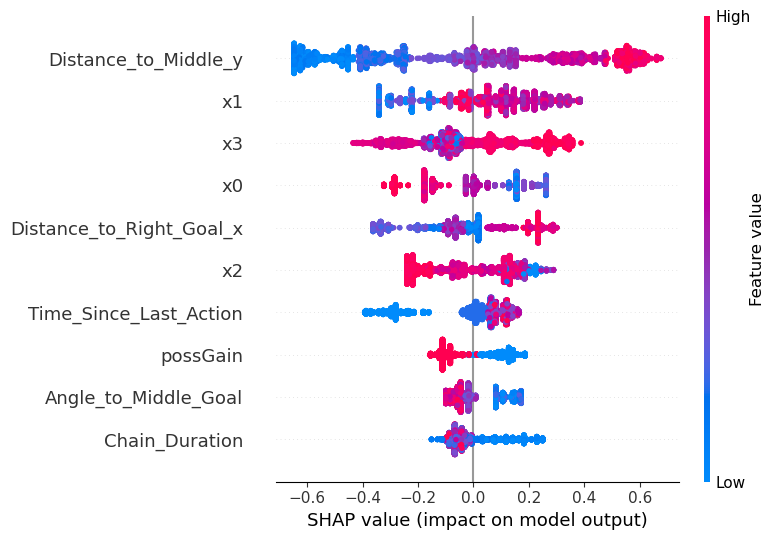

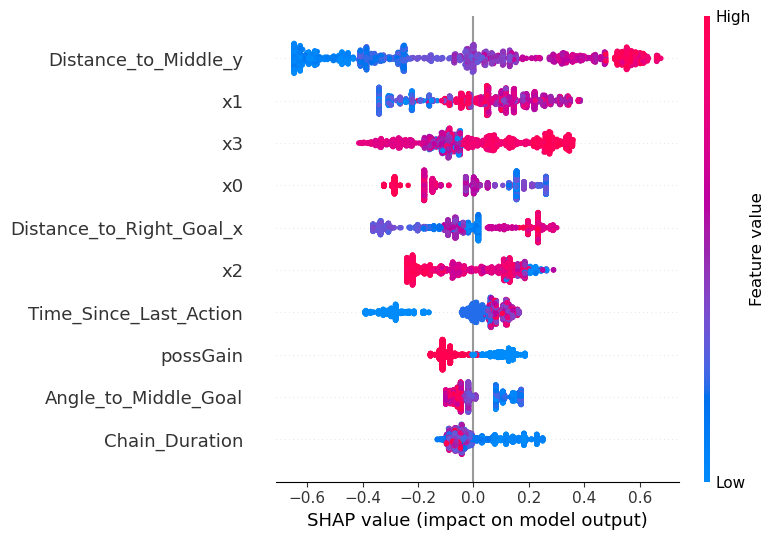

In [31]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [32]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Distance_to_Middle_y',
 'x1',
 'x3',
 'x0',
 'Distance_to_Right_Goal_x',
 'x2',
 'Time_Since_Last_Action',
 'possGain',
 'Angle_to_Middle_Goal',
 'Chain_Duration']

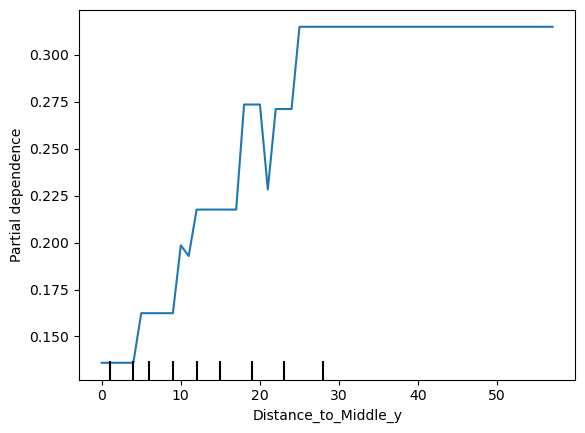

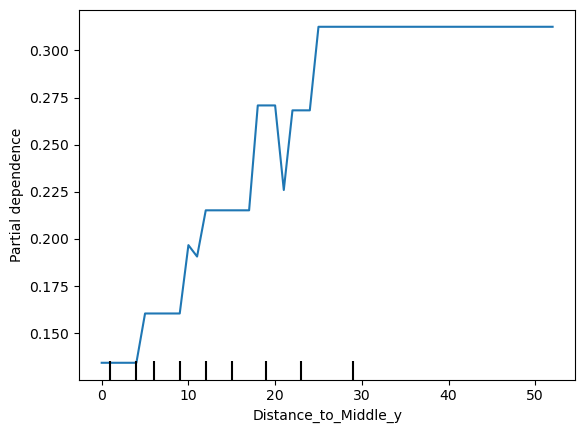

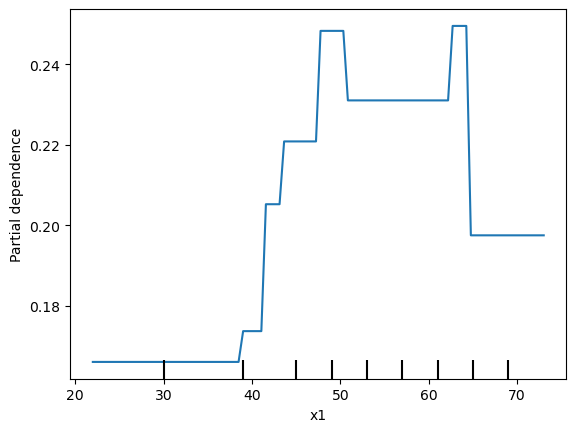

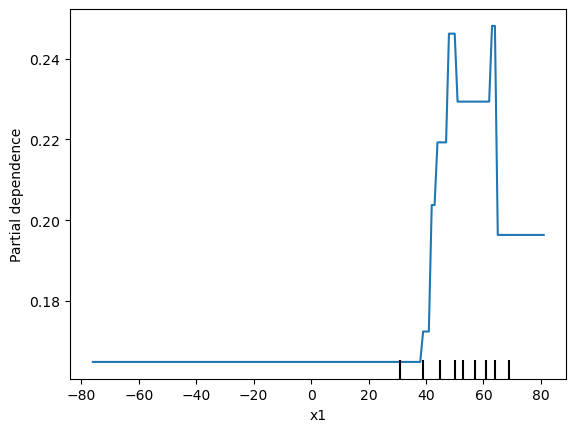

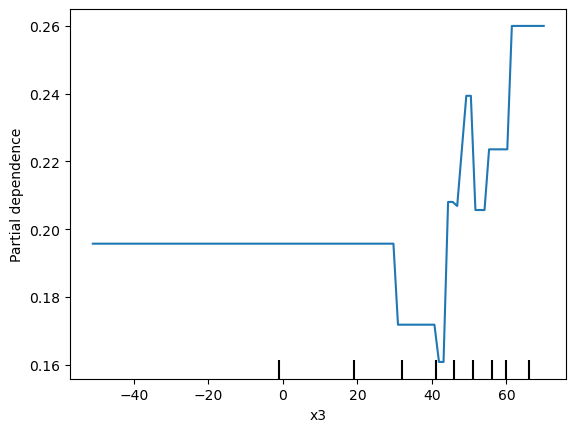

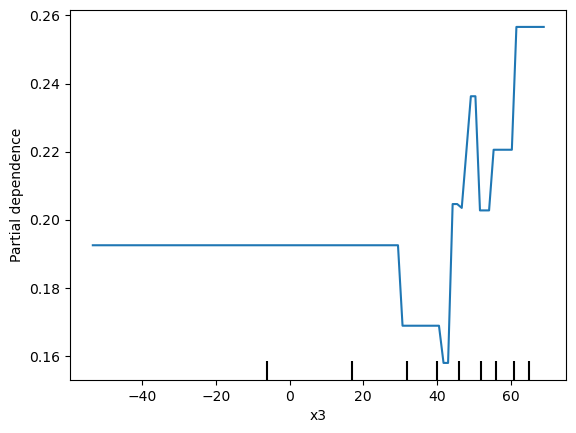

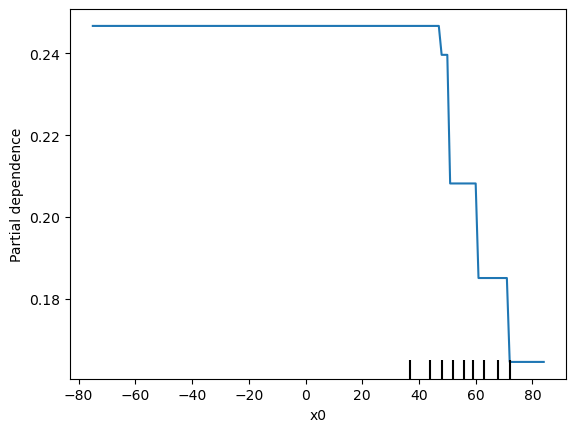

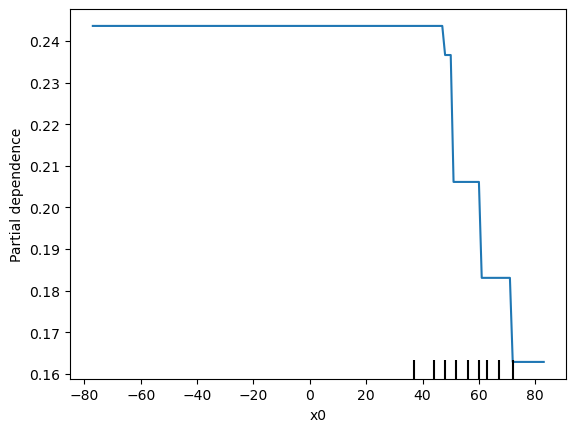

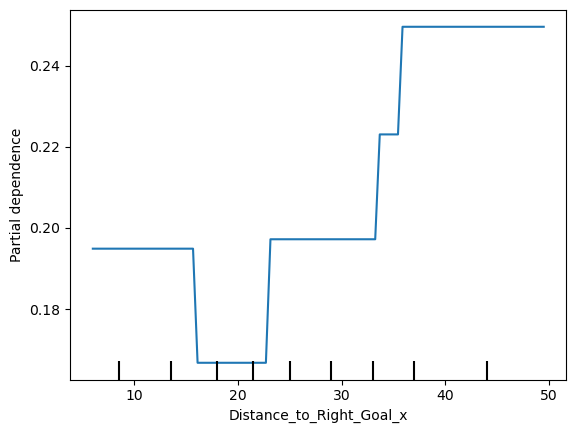

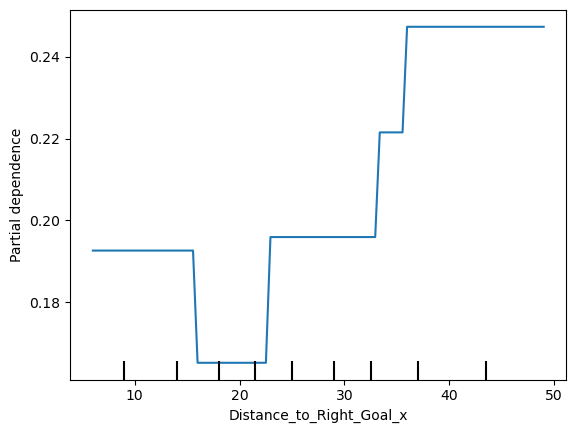

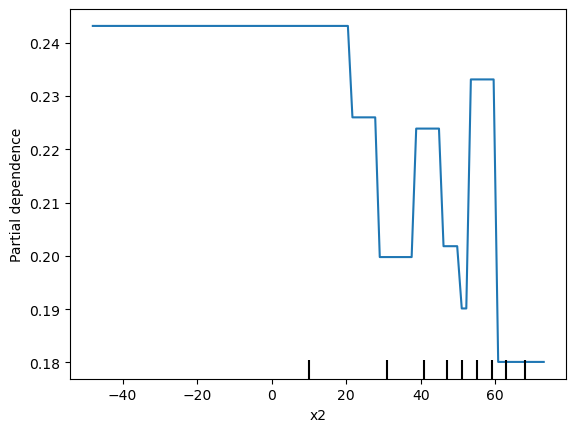

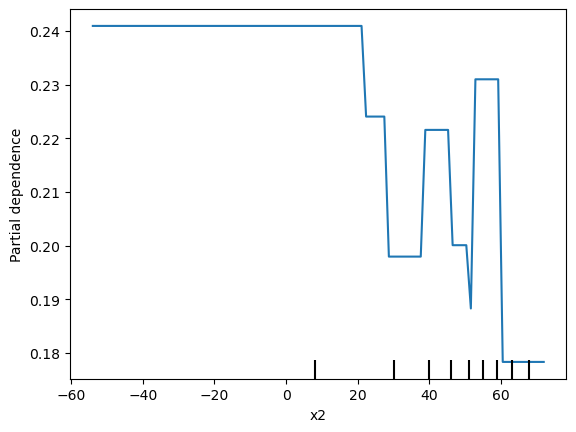

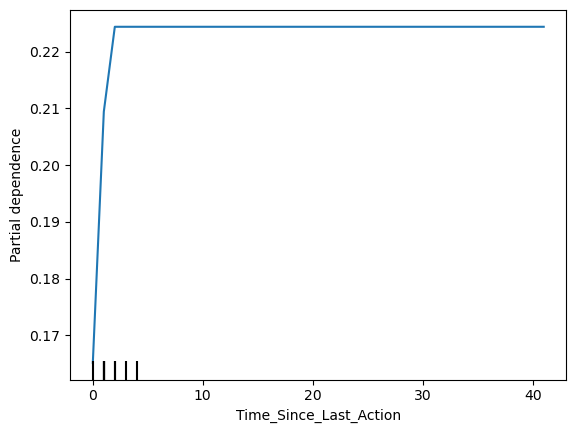

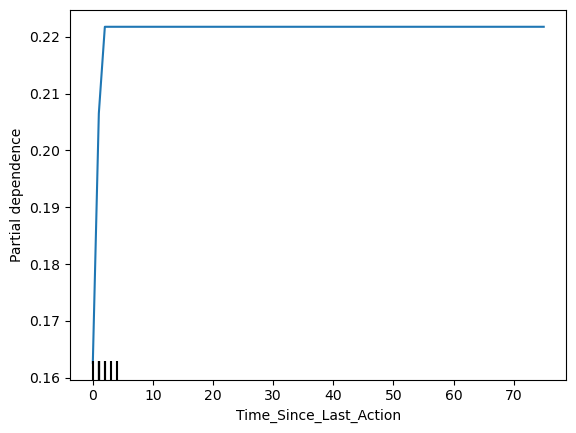

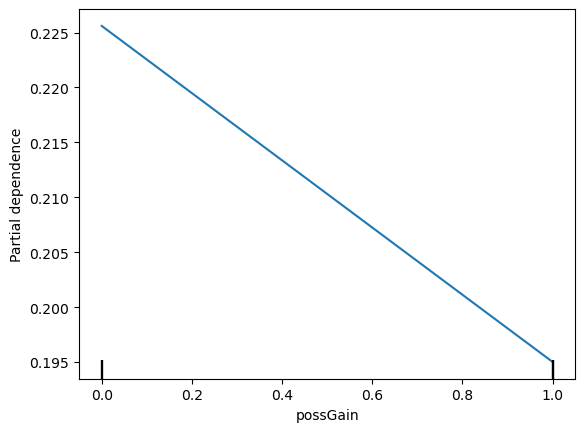

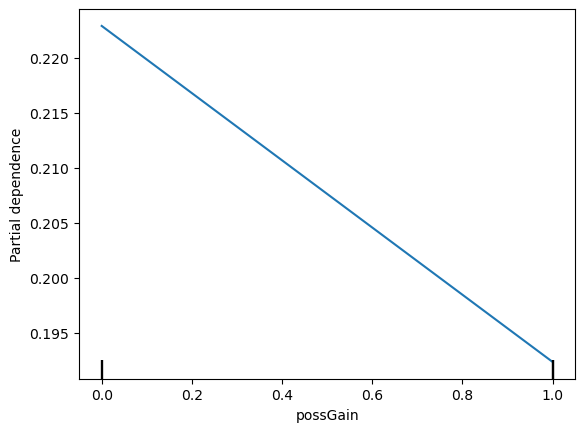

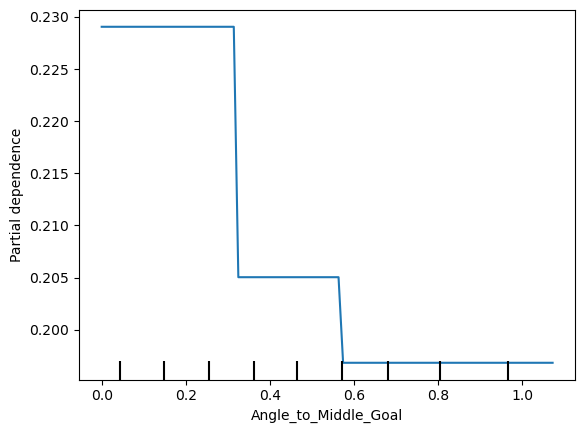

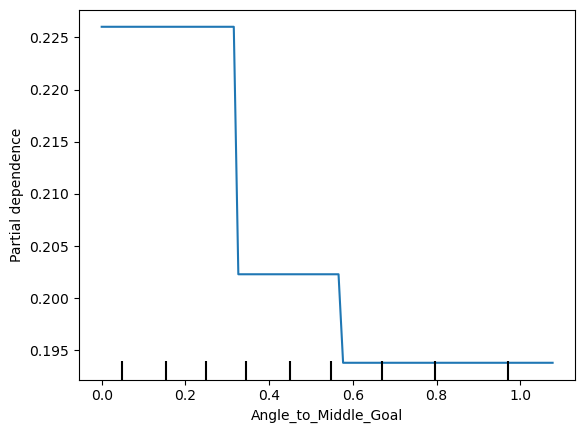

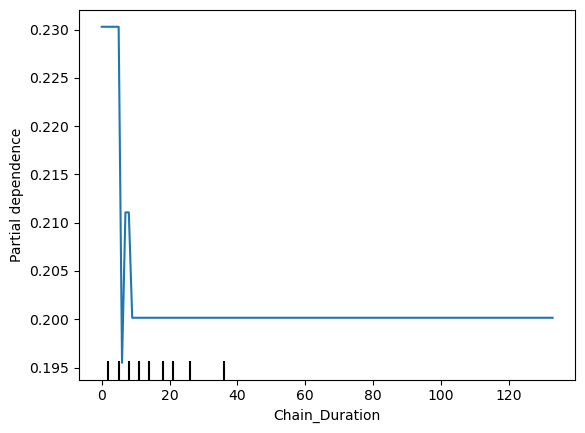

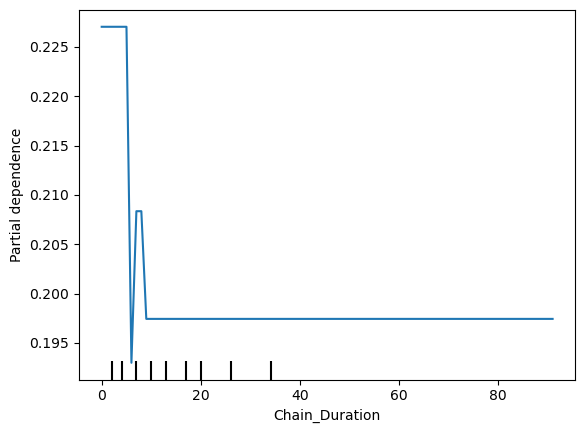

In [33]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

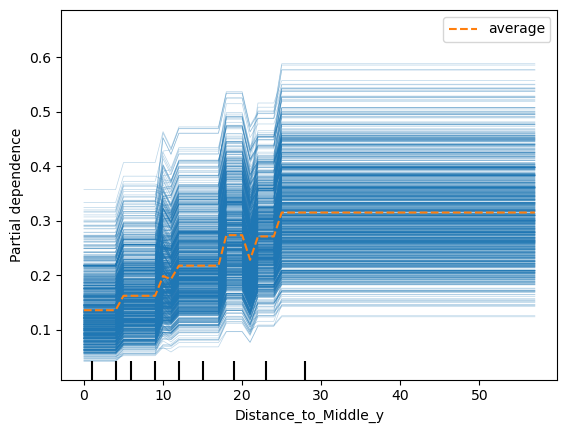

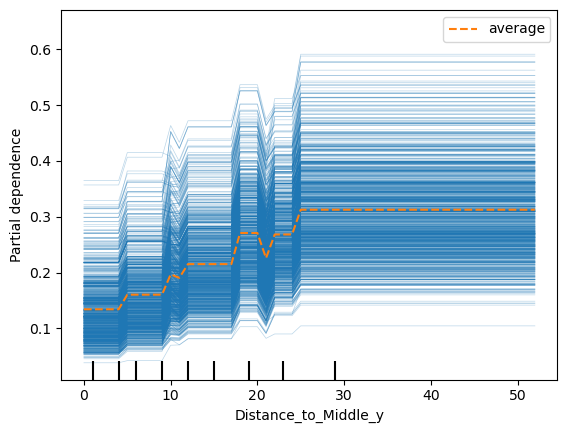

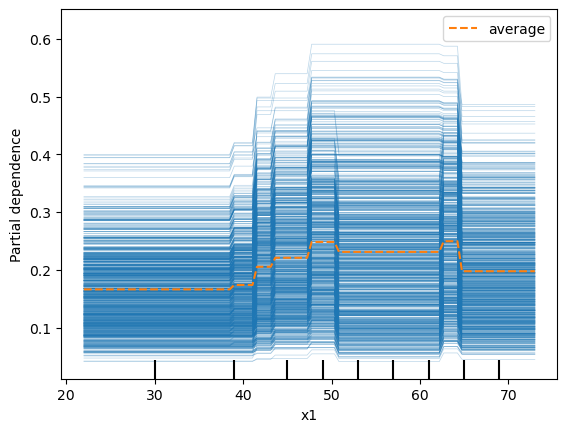

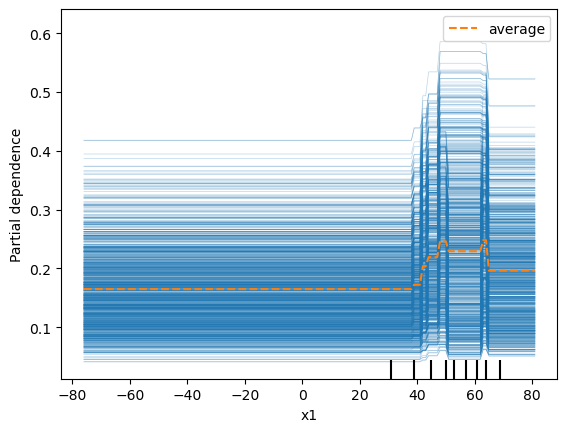

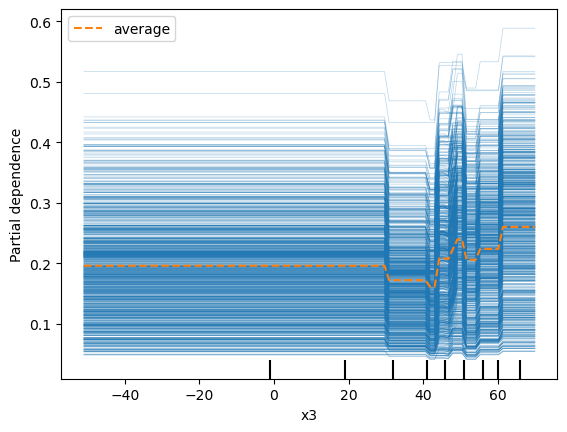

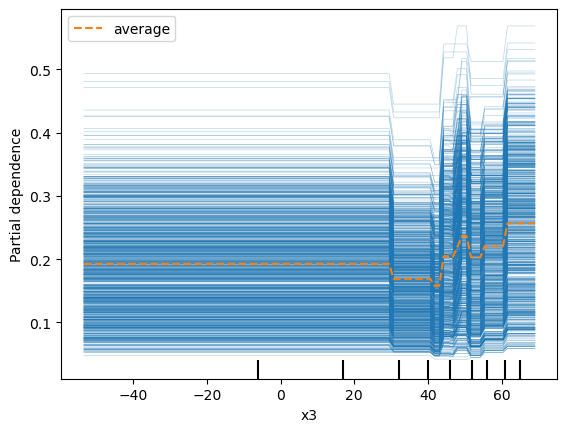

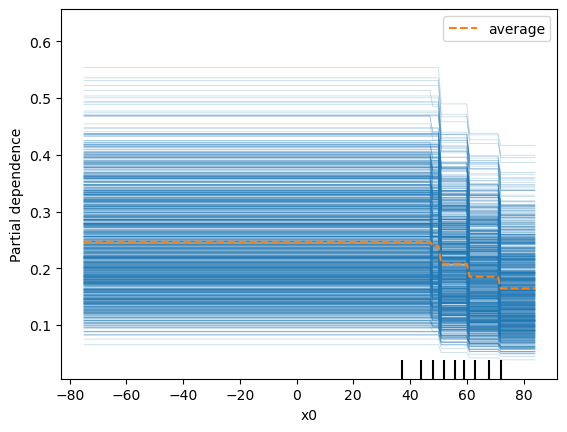

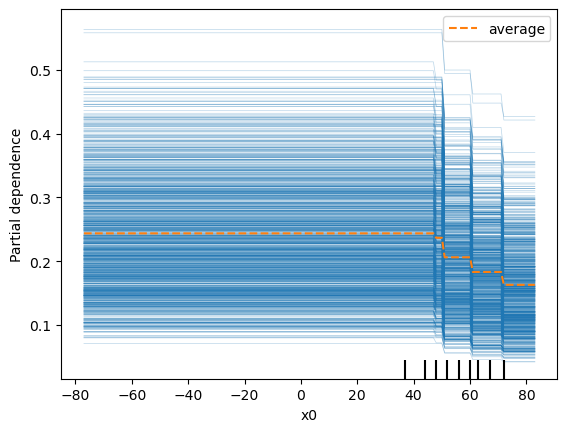

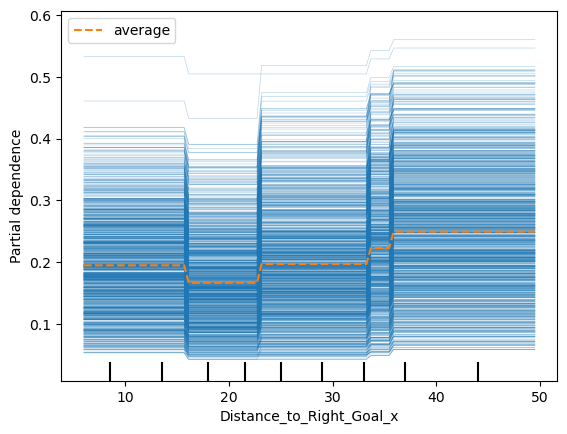

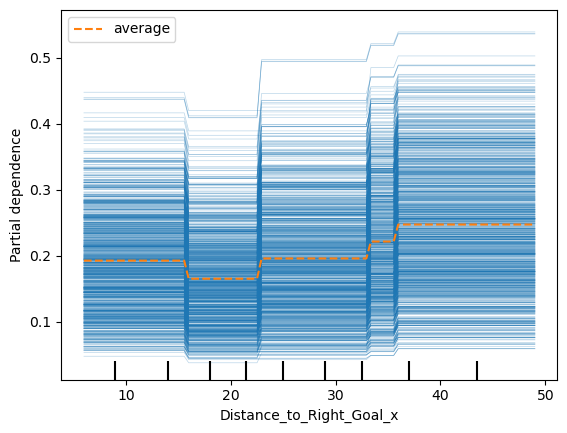

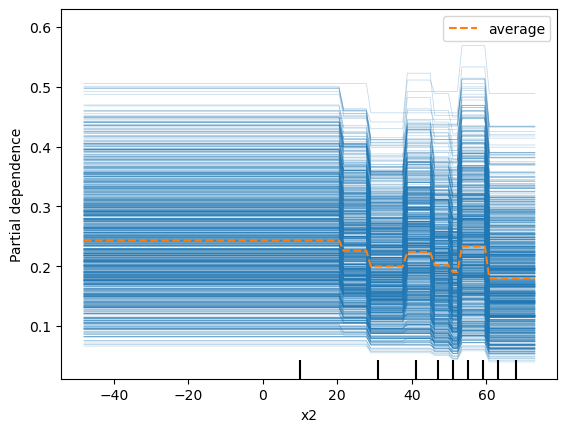

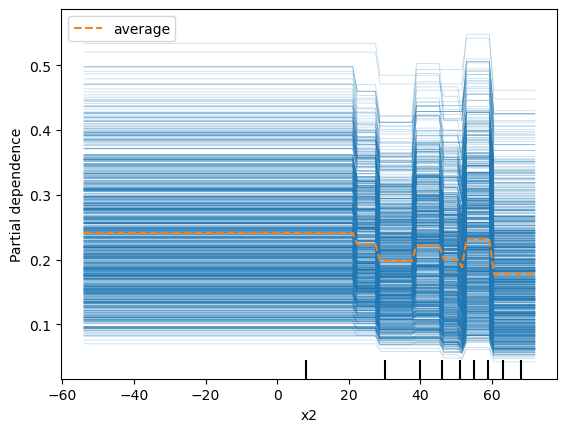

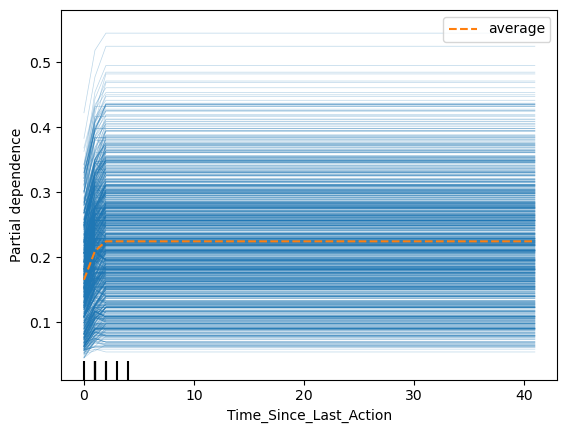

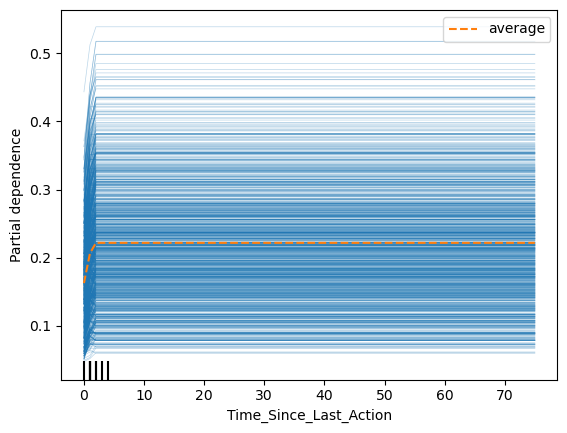

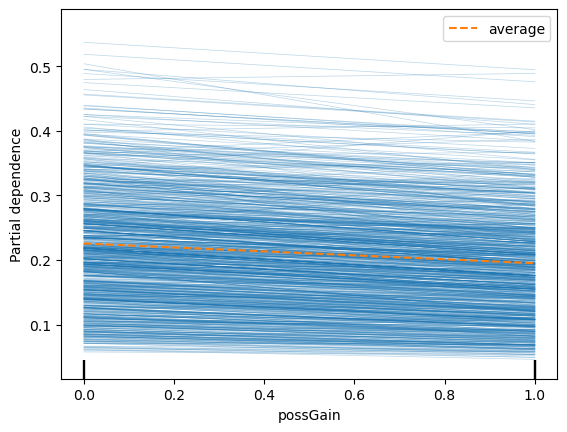

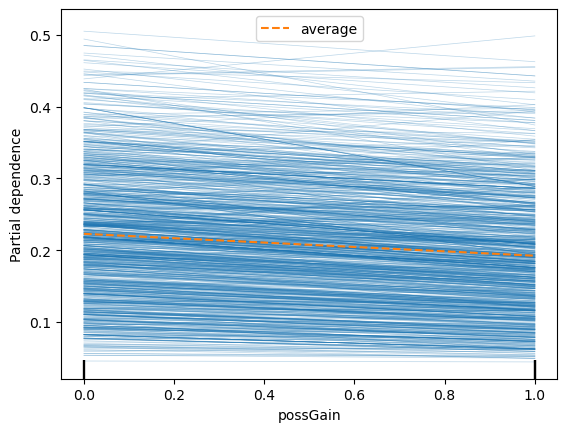

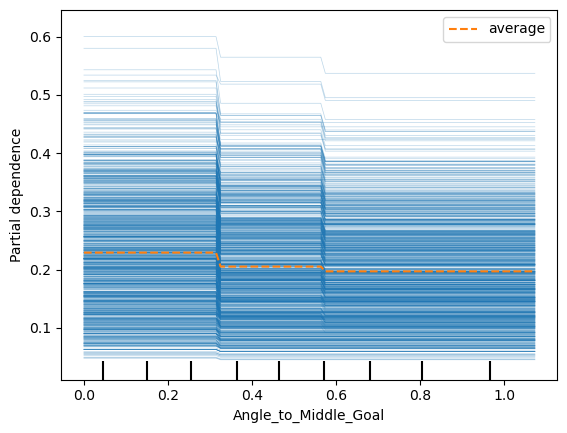

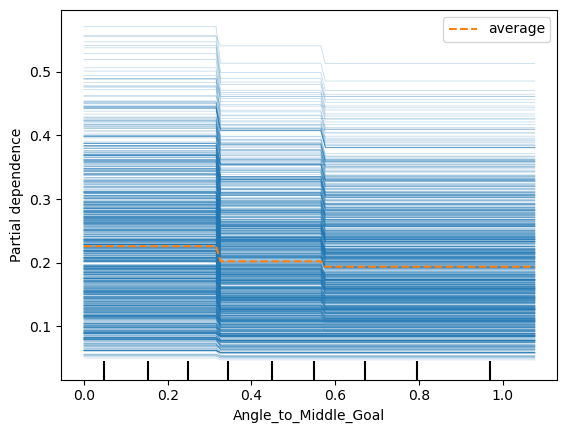

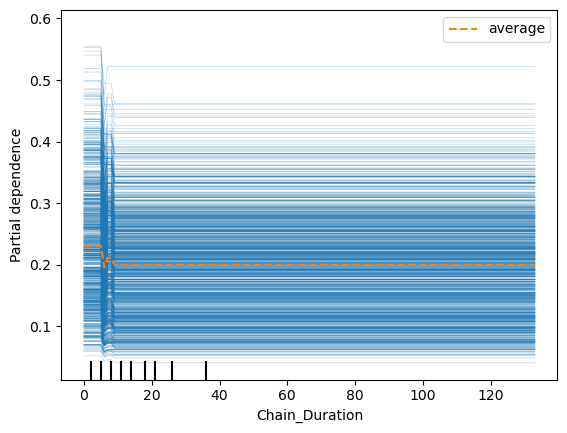

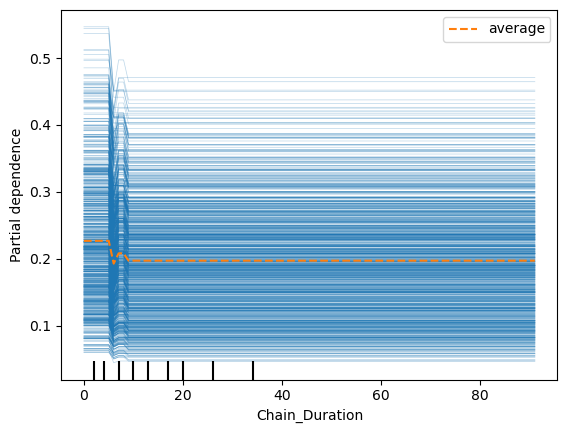

In [34]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

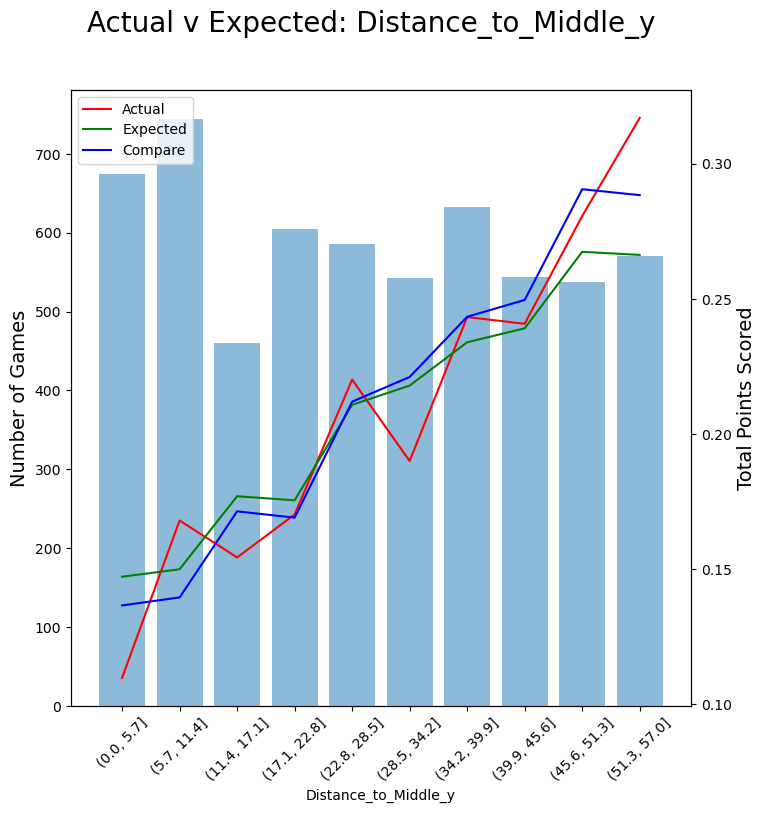

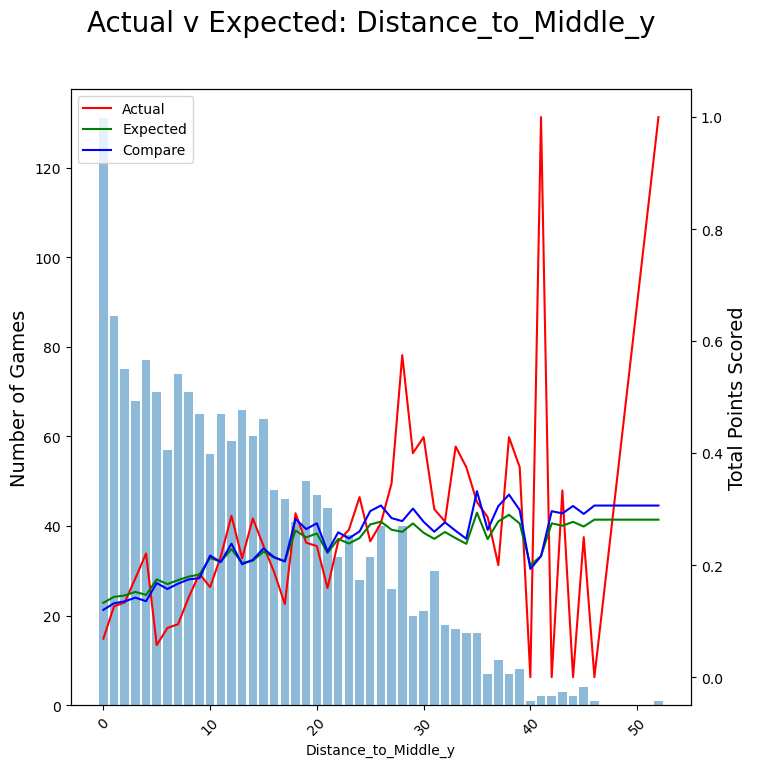

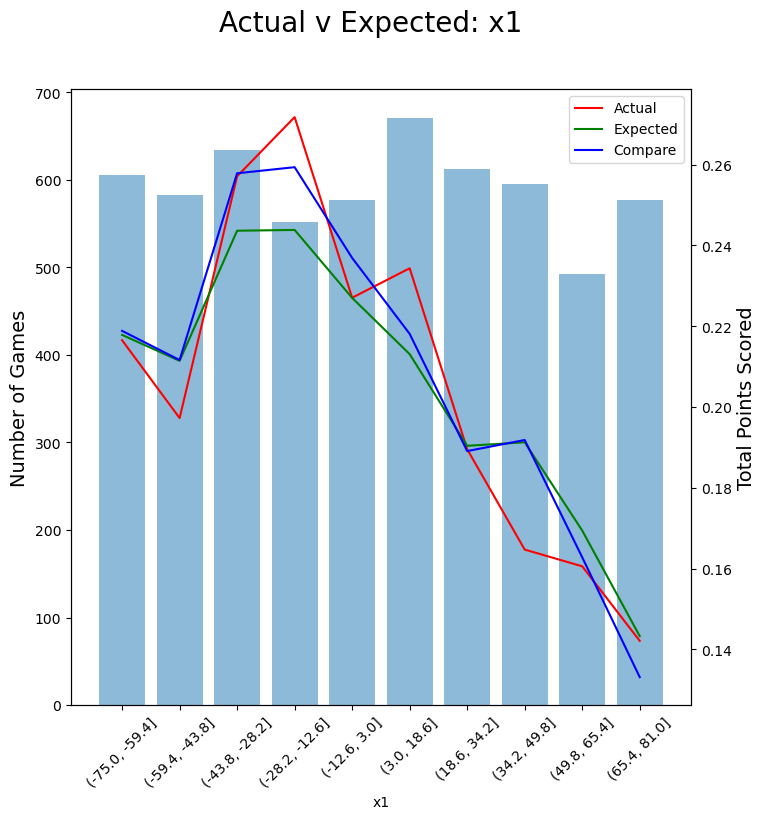

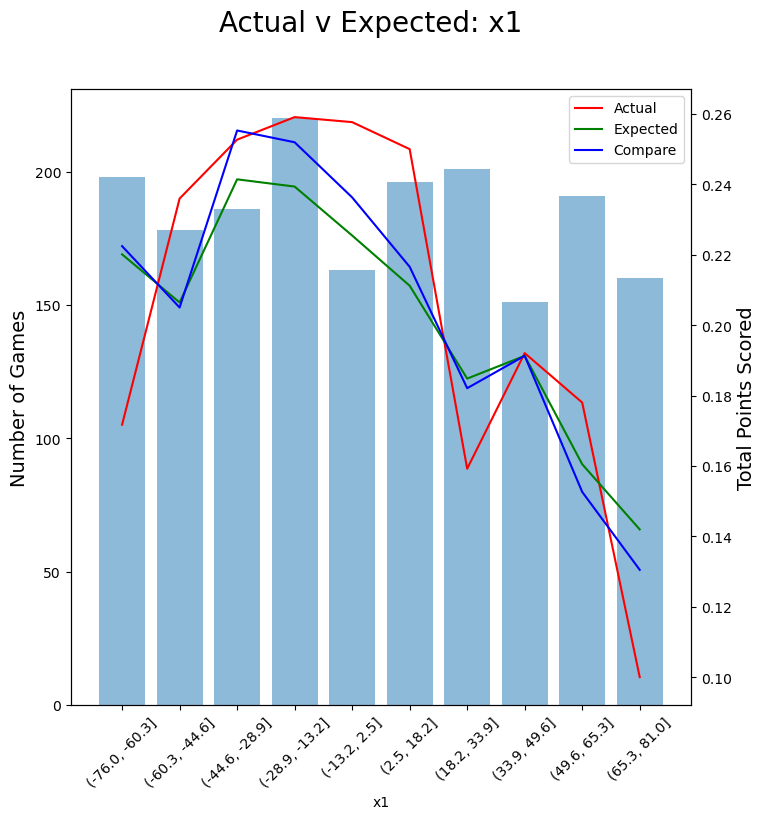

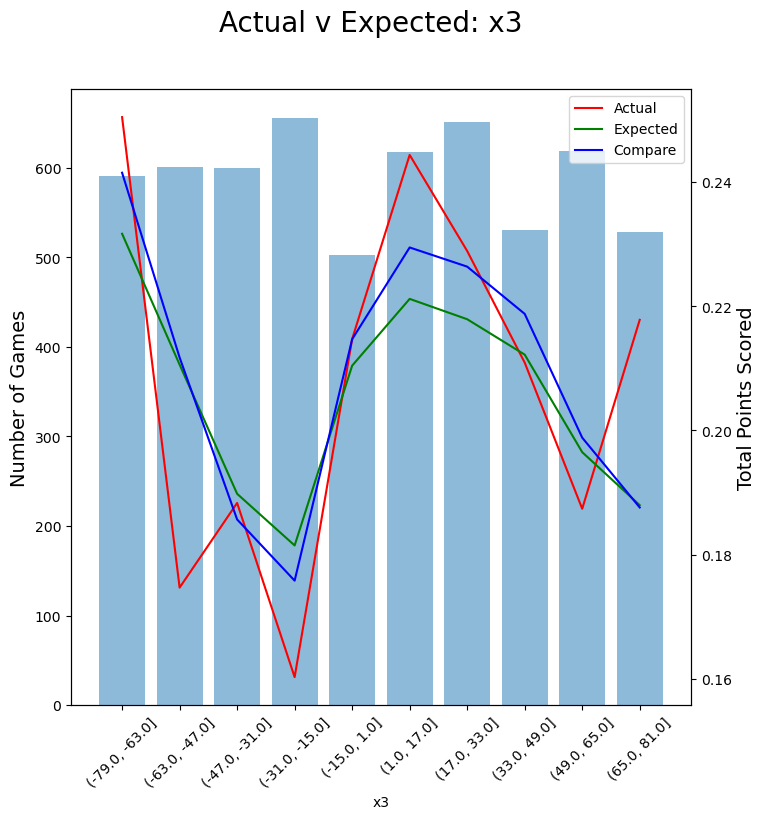

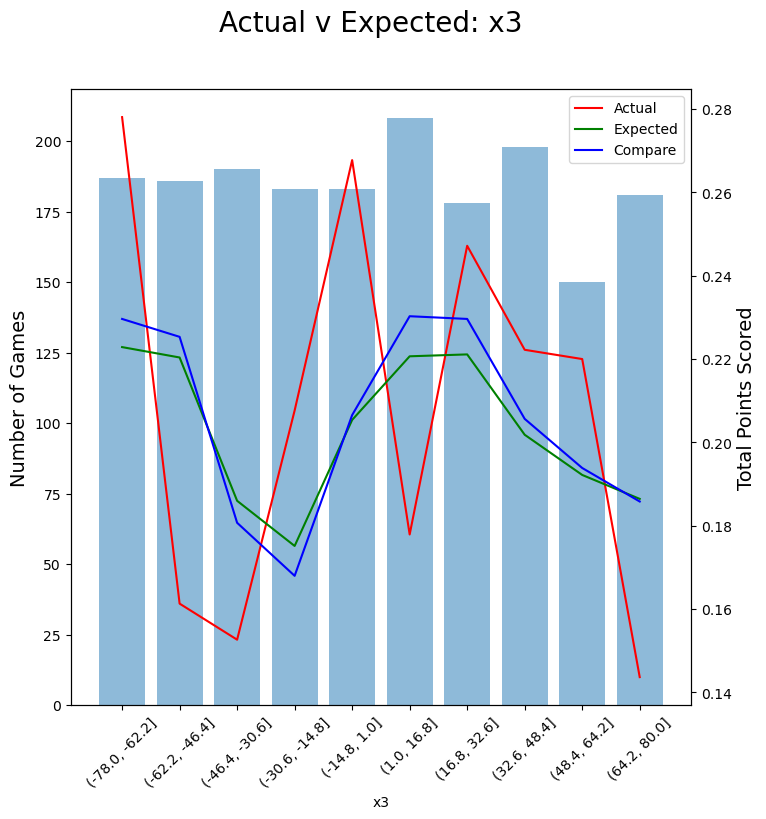

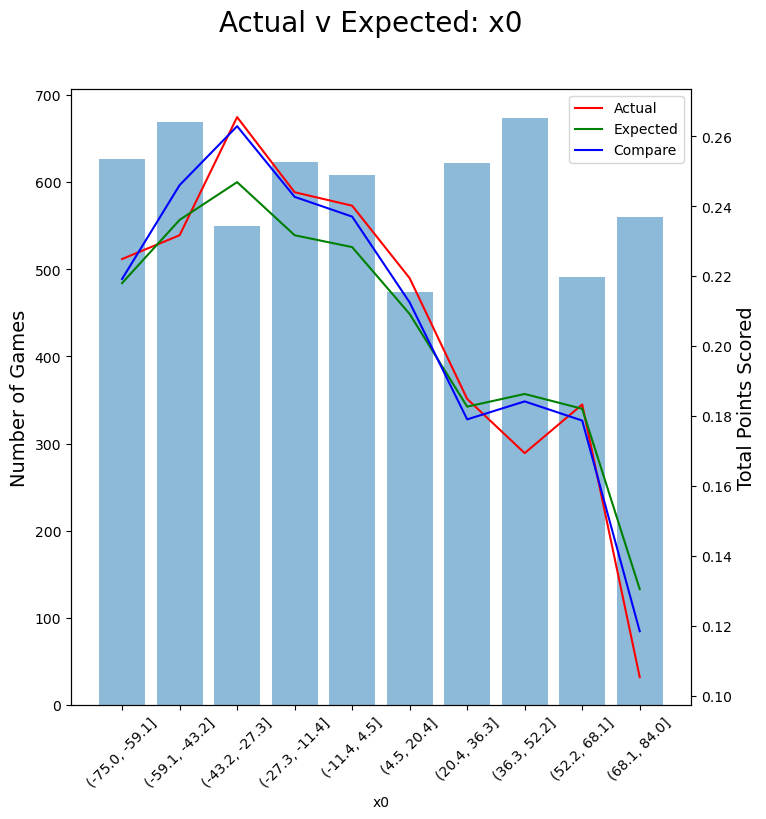

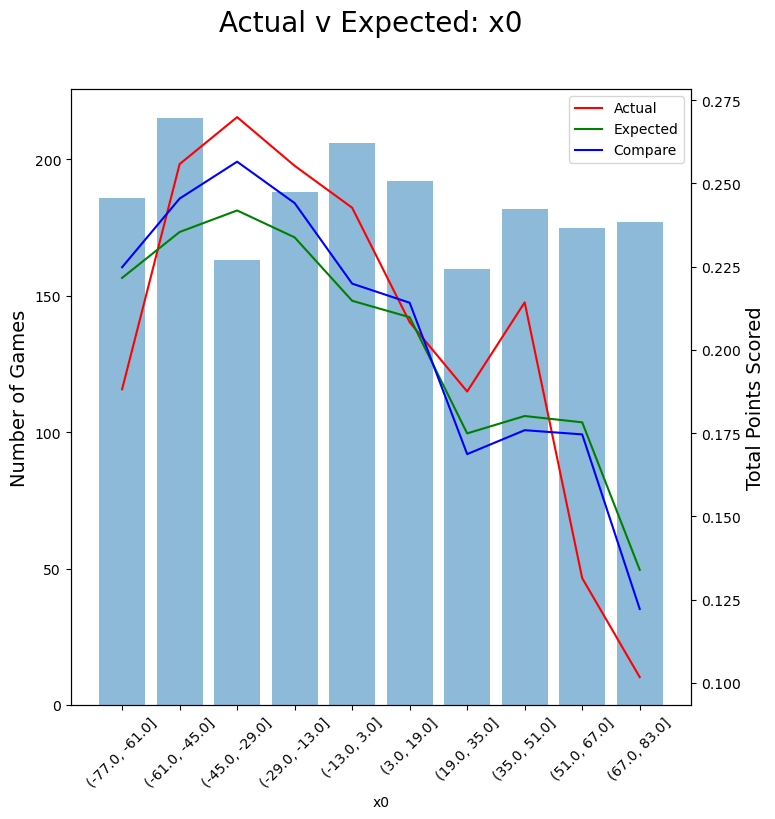

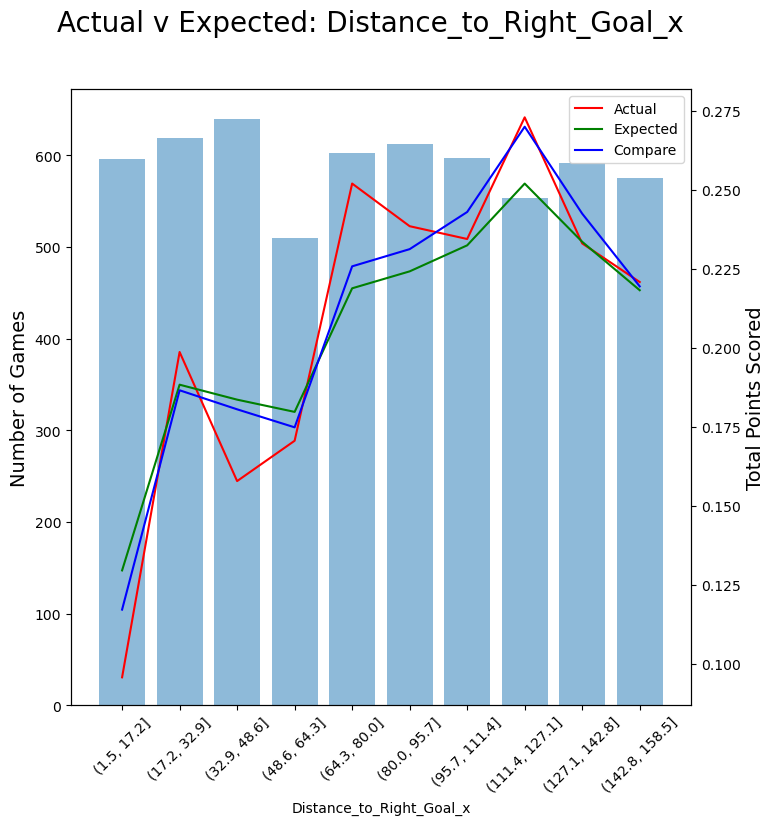

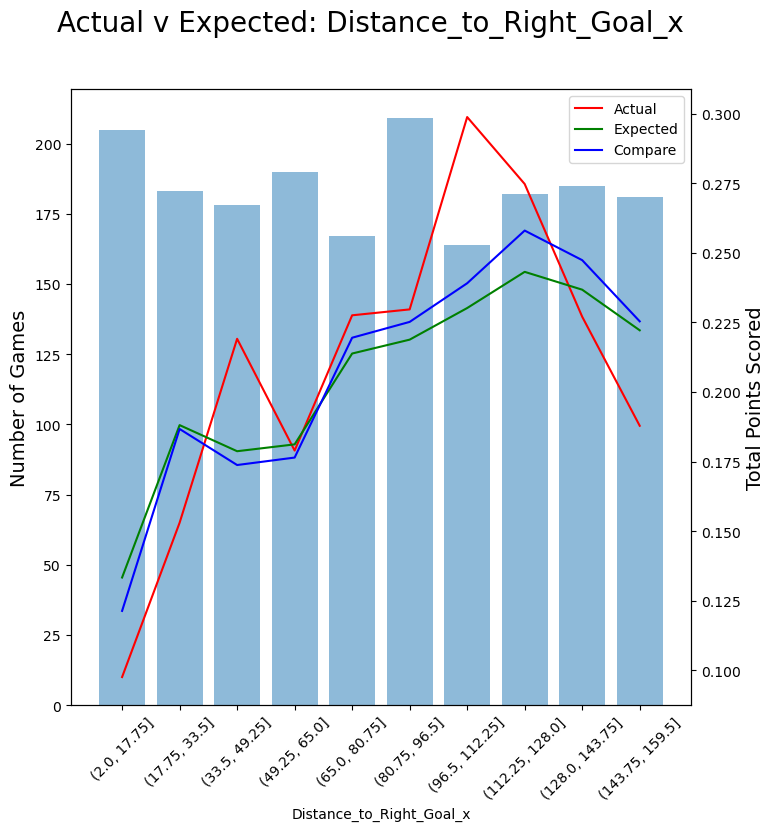

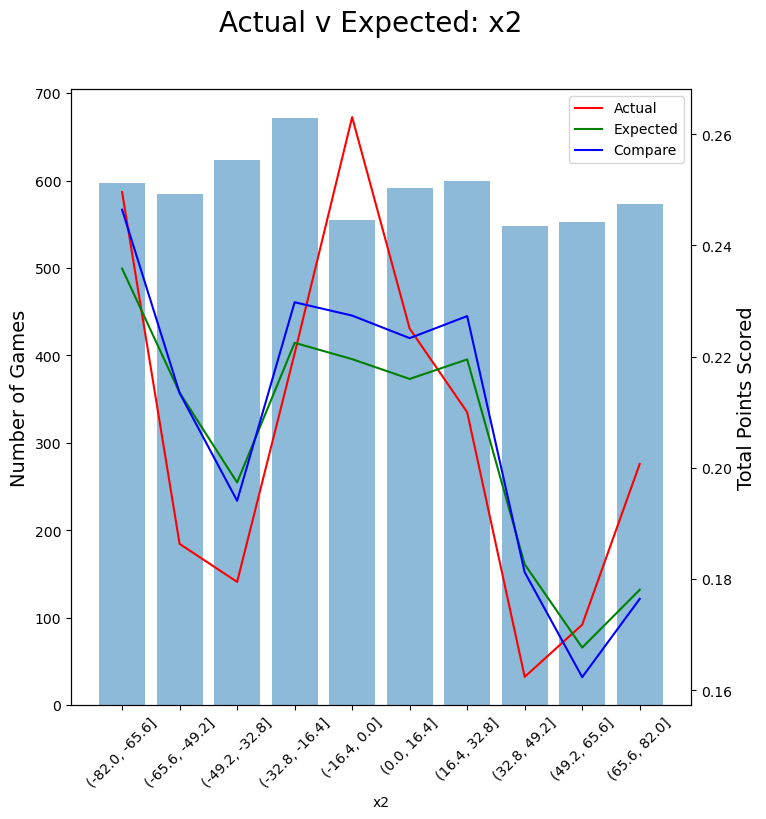

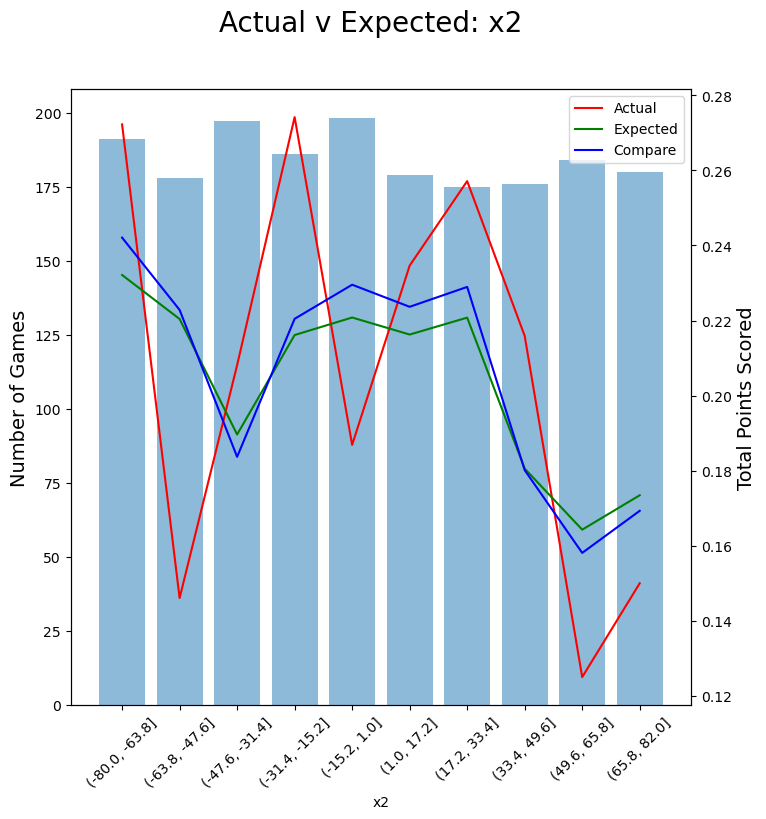

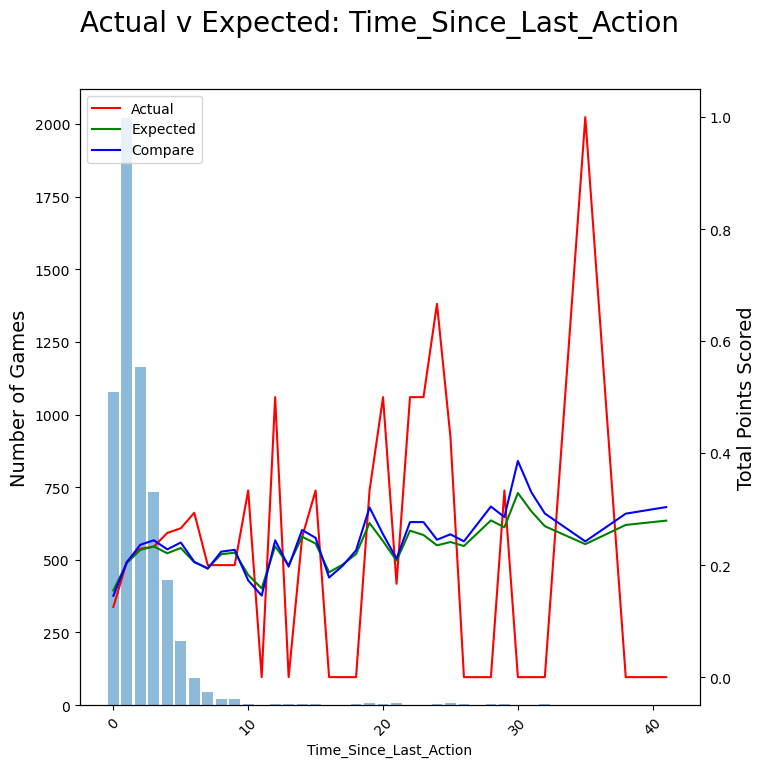

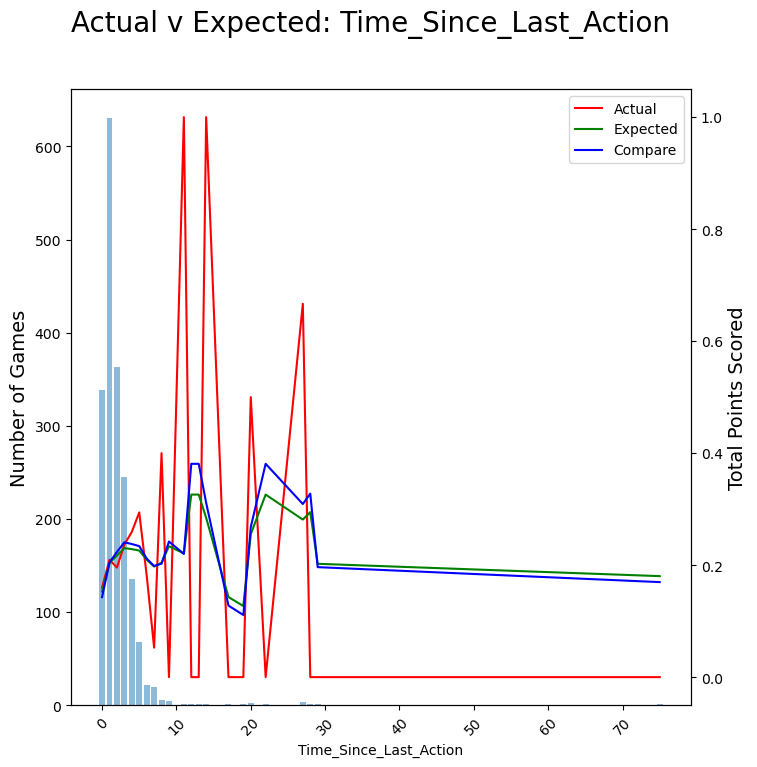

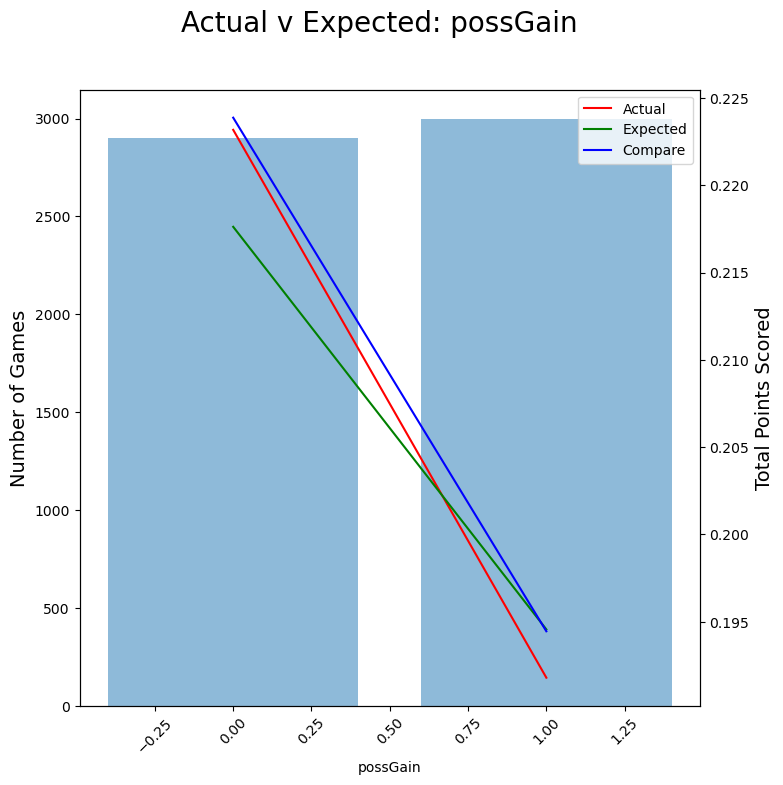

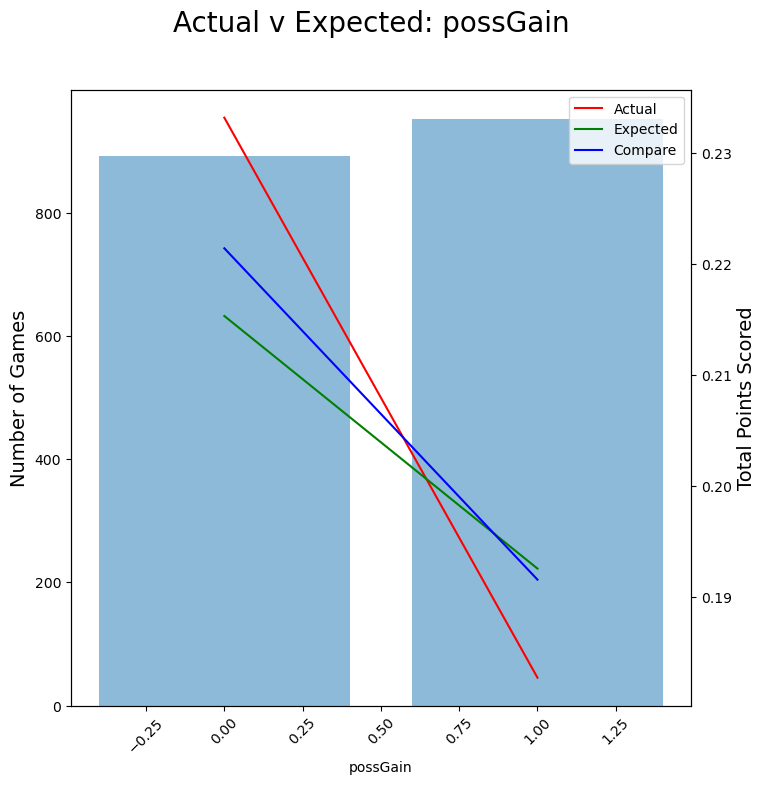

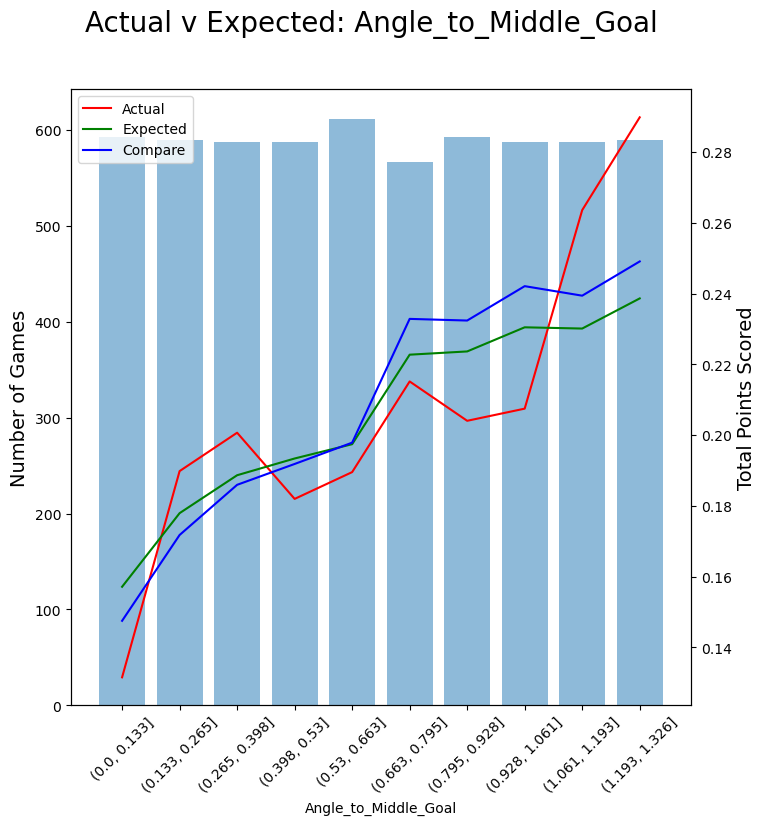

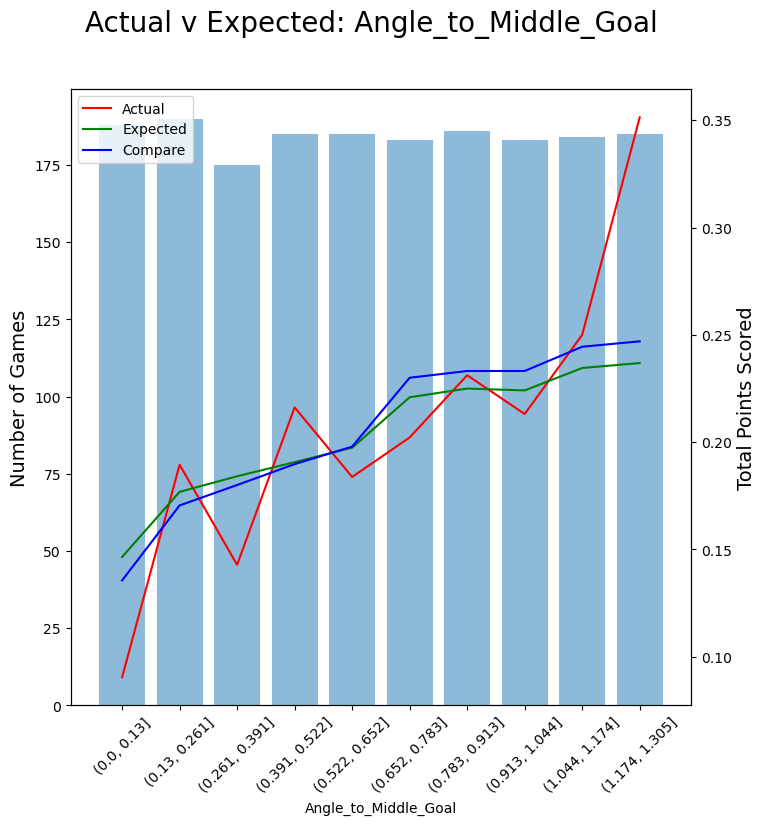

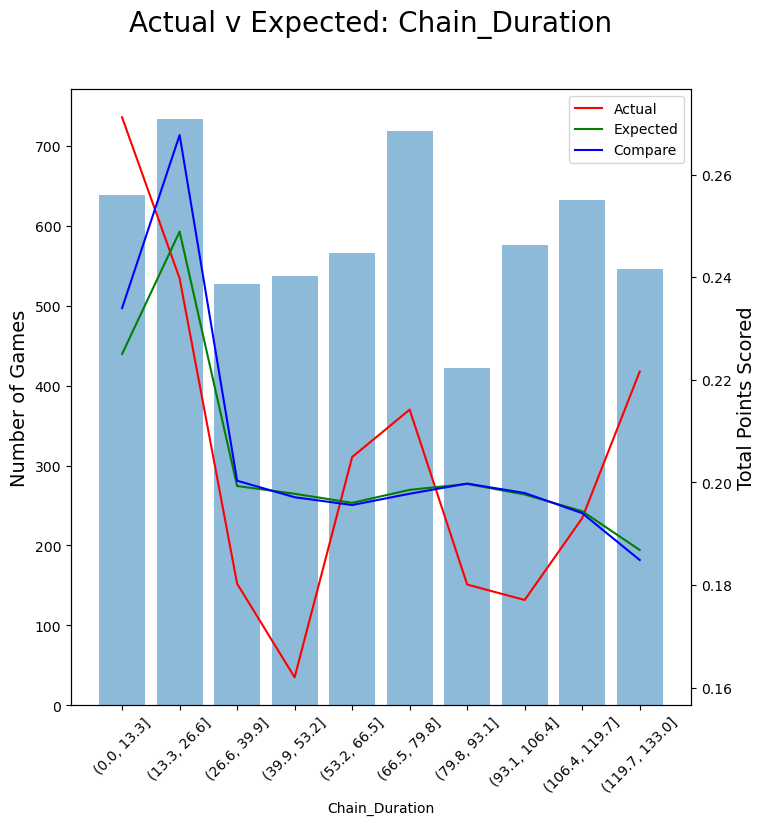

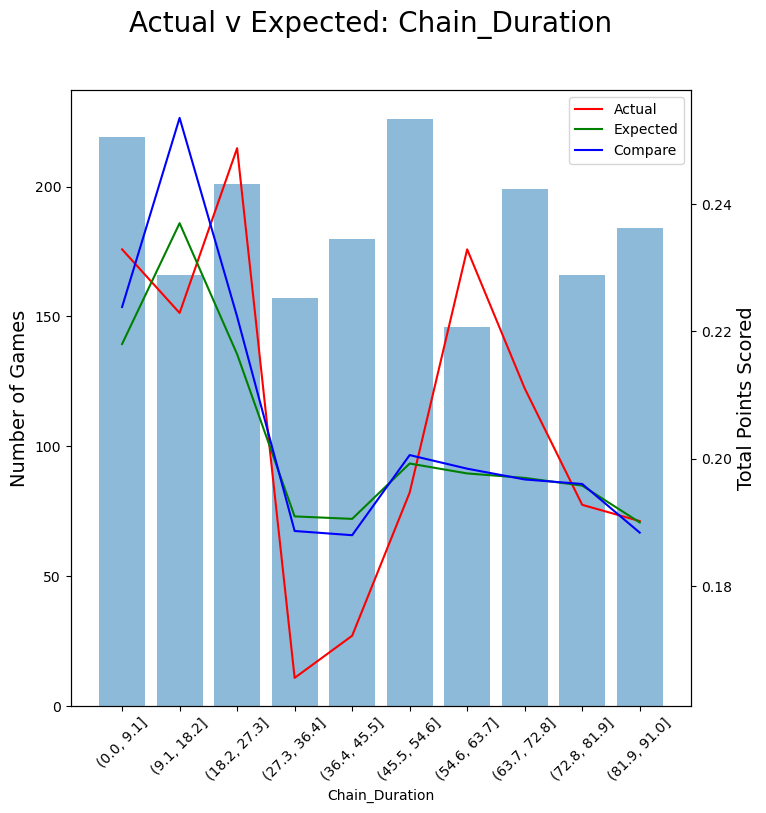

In [35]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [36]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.4830
Compare Log-Loss: 	0.4806
Expected Log-Loss: 	0.4894
Compare Log-Loss: 	0.4893


((0.4829772621344547, 0.4829772621344547),
 (0.4894279039715866, 0.4894279039715866))

In [37]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.1557
Compare Brier Score: 	0.1550
Expected Brier Score: 	0.1578
Compare Brier Score: 	0.1578


((0.15569901900604644, 0.15497912509329073),
 (0.15777837456365298, 0.15782823307829585))

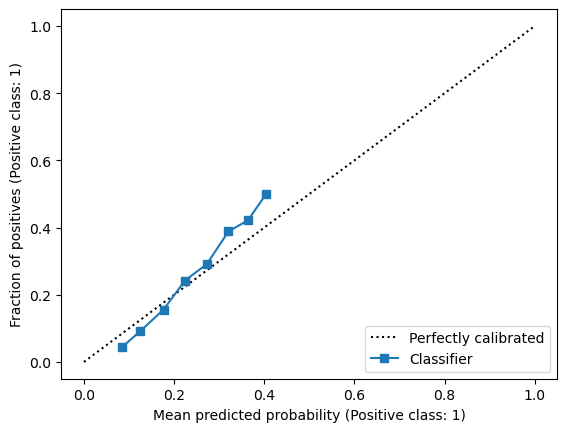

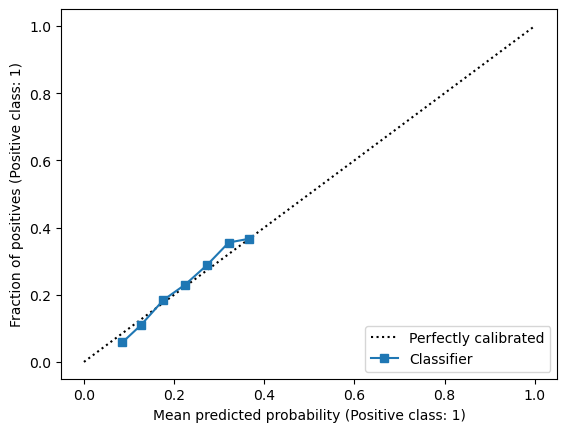

In [38]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

Potential New Features

In [ ]:
# list(df_modelling)

In [ ]:
potential_feature_list = [
    'Initial_State',
    'x0',
    'x1',
    'x2',
    'x3',
    'y0',
    'y1',
    'y2',
    'y3',
    'Quarter_Duration0',
    'Chain_Duration',
    'Time_Since_Last_Action',
    'Distance_Since_Last_Action',
    'Distance_to_Right_Goal_x',
    'Distance_to_Middle_y',
    'Visible_Goal_Angle',
    'Visible_Behind_Angle',
    'Squared_Distance_to_Middle_Goal',
    'Log_Distance_to_Middle_Goal'
]

In [ ]:
for col in potential_feature_list:
    train_xgb_evals.plot_feature_ave(col)